# Exercise 3: Linear Prediction

In [17]:
import librosa
import numpy as np
from scipy.linalg import solve_toeplitz
from scipy.signal import get_window
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 5)

In [18]:
# "Import" functions from exercise 1

import requests

gist = requests.get(
    "https://gist.githubusercontent.com/iibrahimli/3c50f73020c78aeee1de68ae5a0ba5e7/raw/import_funcs.py"
).text
print("Downloaded import_funcs.py")
exec(gist)

import_function_from_ipynb(
    "exercise1.ipynb",
    [
        "plot_signal",
    ],
)

Downloaded import_funcs.py
Found exercise1.ipynb: /Users/imran/Desktop/studies/suse_23/speech_sp/Exercise1/exercise1.ipynb
Executed function plot_signal
Successfully imported functions: ['plot_signal']


## 1. Load `speech1.wav`

In [19]:
s, fs = librosa.core.load("../Exercise2/Audio/speech1.wav")
s.shape, fs

((62658,), 22050)

## 2. Select voiced and unvoiced segments

In [20]:
segment_len = int(32 / 1000 * fs) # 32 ms
voiced_start = int(400 / 1000 * fs) # 400 ms
unvoiced_start = int(550 / 1000 * fs) # 550 ms

voiced_s = s[voiced_start:voiced_start+segment_len]
unvoiced_s = s[unvoiced_start:unvoiced_start+segment_len]

# Apply the Hann window to the voiced and unvoiced segments
window = get_window("hann", segment_len)
voiced_s = voiced_s * window
unvoiced_s = unvoiced_s * window

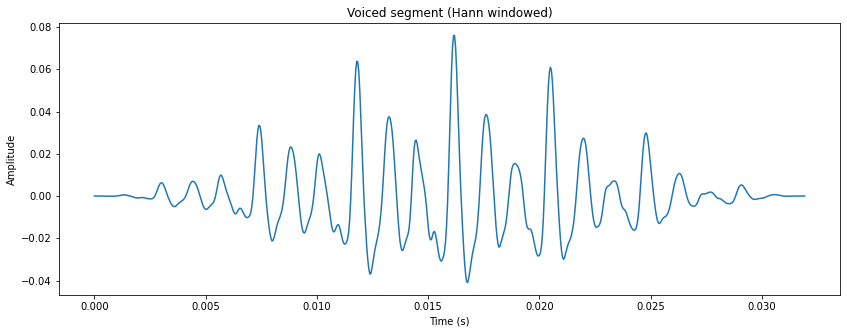

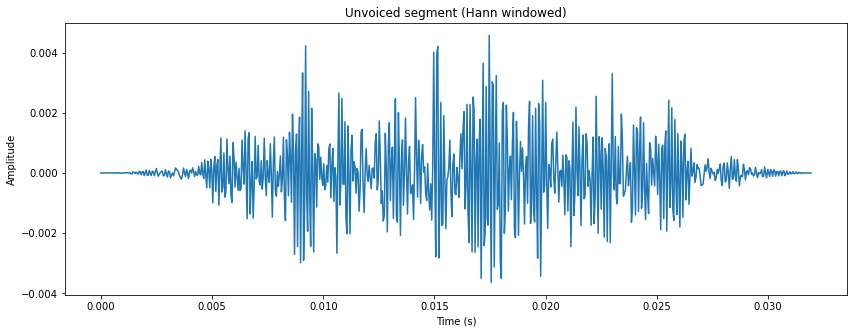

In [21]:
plot_signal(voiced_s, fs, "Voiced segment (Hann windowed)")
plot_signal(unvoiced_s, fs, "Unvoiced segment (Hann windowed)")

## 3. Compute LP coefficients

In [25]:
autocorr_vector = np.correlate(voiced_s, voiced_s, mode="full")
autocorr_vector = autocorr_vector[autocorr_vector.size // 2:]